In [1]:
import os
import numpy as np
from astropy.io import fits
from glob import glob
import pandas as pd

from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground, SExtractorBackground

from imagedaemon.paths import CAL_DATA_DIR, RAW_DATA_DIR
from imagedaemon.image.winter_image import WinterImage
from imagedaemon.image.image_operations import plot_image, write_image

# Set up the paths to the calibration data
camname = "winter"
MASTERFLAT_DIR = os.path.join(CAL_DATA_DIR, camname, "masterflats")
MASTERDARK_DIR = os.path.join(CAL_DATA_DIR, camname, "masterdarks")
MASTERBIAS_DIR = os.path.join(CAL_DATA_DIR, camname, "masterbiases")


_PROJECT_ROOT = /Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon
CONFIG_DIR = /Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/config
astro_scamp = /Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/config/scamp.conf
masterbias_dir = /Users/nlourie/data/image-daemon-data/calibration/masterbias


Looking for background files in /Users/nlourie/data/image-daemon-data/raw/winter/science
Found 8 files to process
Using 8 files to process
Found 8 target frame files to process
Using target frame file: /Users/nlourie/data/image-daemon-data/raw/winter/science/WINTERcamera_20250423-075115-102_mef.fits
Science image exposure time: 120.0 seconds
Found masterdark with matching exposure time: winter_masterdark_120.000s.fits
Using addrs: ['sa', 'sb', 'sc', 'pa', 'pb', 'pc']
Shape of median data for addr sa: (1096, 1984)
Shape of median data for addr sb: (1096, 1984)
Shape of median data for addr sc: (1096, 1984)
Shape of median data for addr pa: (1096, 1984)
Shape of median data for addr pb: (1096, 1984)
Shape of median data for addr pc: (1096, 1984)


/var/folders/v4/c0sck65j1l3cwj3lsnz2fs380000gn/T/ipykernel_32069/2596727946.py:96: RuntimeWarning: divide by zero encountered in divide
  plot_image(science_raw_image_darksub[sample_addr]/dither_flat_data[sample_addr], title = f"Dark Sub Image / Dither Flat {sample_addr}")
/var/folders/v4/c0sck65j1l3cwj3lsnz2fs380000gn/T/ipykernel_32069/2596727946.py:96: RuntimeWarning: invalid value encountered in divide
  plot_image(science_raw_image_darksub[sample_addr]/dither_flat_data[sample_addr], title = f"Dark Sub Image / Dither Flat {sample_addr}")
/var/folders/v4/c0sck65j1l3cwj3lsnz2fs380000gn/T/ipykernel_32069/2596727946.py:112: RuntimeWarning: divide by zero encountered in divide
  dither_flattened_data[addr] = science_raw_image_darksub[addr] / dither_flat_data[addr]
/var/folders/v4/c0sck65j1l3cwj3lsnz2fs380000gn/T/ipykernel_32069/2596727946.py:112: RuntimeWarning: invalid value encountered in divide
  dither_flattened_data[addr] = science_raw_image_darksub[addr] / dither_flat_data[addr]
/U

Sample data row flat shape: (1096,)
float32 float32 float32
Saving dither flattened image to /Users/nlourie/data/image-daemon-data/raw/winter/tmp/dither_flattened_pc.fits


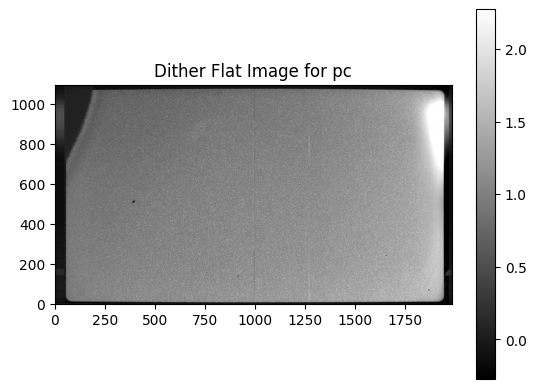

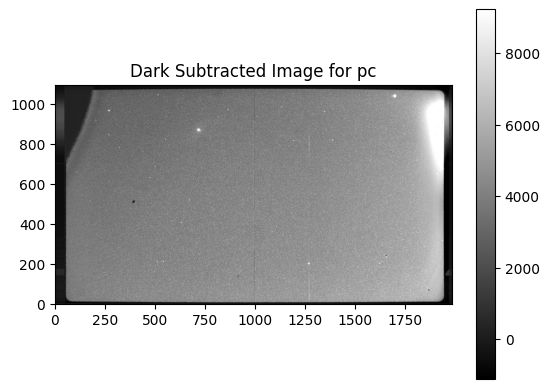

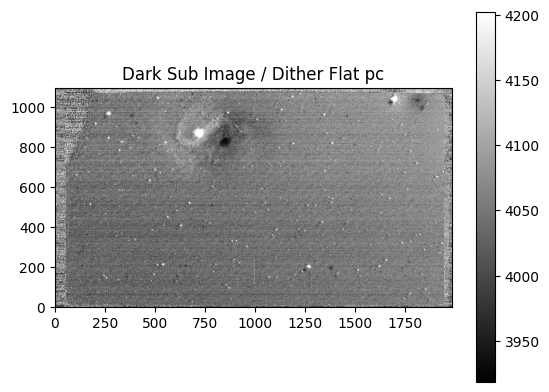

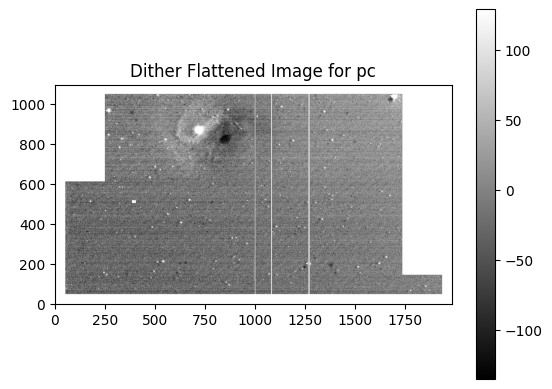

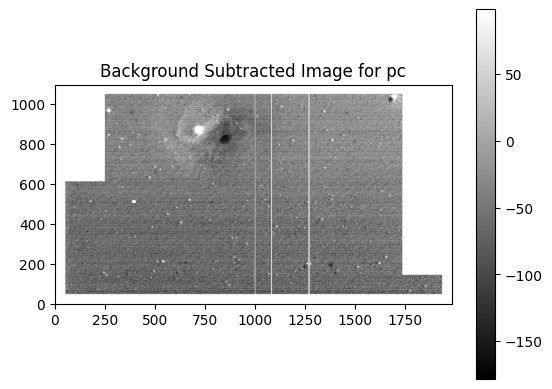

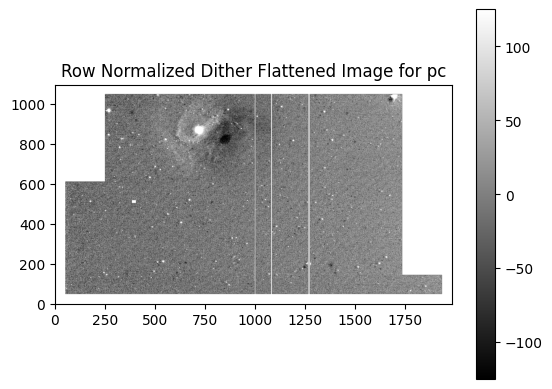

In [ ]:
""""
the idea is to:
1. take a set of 4 dithered images
2. make a dither flat by median combining the 4 images and dividing by the median
3. dark subtract the dither flat
4. dark subtract the target frame
4. analyze the target frame:
    1. divide the target frame by the dither flat
"""
## Load in the background files, eg the first 3 images from the dither set
# set 30 s images:
background_file_dir = os.path.join(RAW_DATA_DIR, camname, "science", "30s", "bkg")
# 120 s images:
background_file_dir = os.path.join(RAW_DATA_DIR, camname, "science")

print(f"Looking for background files in {background_file_dir}")
background_files = glob(os.path.join(background_file_dir, "*_mef.fits"))
print(f"Found {len(background_files)} files to process")
n_background_images_to_use = 12
background_files = background_files[:n_background_images_to_use]
print(f"Using {len(background_files)} files to process")

## Load in the target frame files, eg the last image from the dither set
#target_frame_file_dir = os.path.join(RAW_DATA_DIR, camname, "focus", "bestfocus")
target_frame_file_dir = os.path.join(RAW_DATA_DIR, camname, "science", "30s")
# 120 s images
target_frame_file_dir = os.path.join(RAW_DATA_DIR, camname, "science")

target_frame_files = glob(os.path.join(target_frame_file_dir, "*_mef.fits"))
print(f"Found {len(target_frame_files)} target frame files to process")
if len(target_frame_files) == 0:
    raise FileNotFoundError("No target frame files found in the specified directory.")
target_frame_file = target_frame_files[-1]
print(f"Using target frame file: {target_frame_file}")
## Load in the science image
science_raw_image = WinterImage(target_frame_file)

## Find the master dark that matches the exposure time of the background files
exposure_time = science_raw_image.top_level_header["EXPTIME"]
print(f"Science image exposure time: {exposure_time} seconds")

masterdark_files = glob(os.path.join(MASTERDARK_DIR, "*.fits"))
for dark_file in masterdark_files:
    dark_image = WinterImage(dark_file)
    if dark_image.top_level_header["EXPTIME"] == exposure_time:
        print(f"Found masterdark with matching exposure time: {os.path.basename(dark_file)}")
        break
else:
    raise FileNotFoundError(f"No masterdark found with exposure time {exposure_time} seconds")

## Dark subtract the background and target frame files
# dark subtract the background files
background_images = []
for background_file in background_files:
    background_image = WinterImage(background_file)
    background_images.append(background_image)

# dark subtract the target frame
science_raw_image_darksub = science_raw_image - dark_image
# add the dark subtracted science image to the list of background images
#background_images.append(science_raw_image_darksub)

## Make a dither flat by median combining the dark subtracted background images

# let's do this sensor by sensor
addrs = WinterImage.get_addrs()
print(f"Using addrs: {addrs}")

median_background_data = dict()
dither_flat_data = dict()
for addr in addrs:
    background_data_for_addr = []
    #print(background_data_darksub)
    for background_data in background_images:
        #print(f"Background data for addr {addr}: {background_data[addr].shape}")
        background_data_for_addr.append(background_data[addr])
    background_data_for_addr = np.array(background_data_for_addr)
    # what is the shape of the data?
    #print(f"Shape of background data for addr {addr}: {background_data_for_addr.shape}")
    
    median_data_for_addr = np.nanmedian(background_data_for_addr, axis=0)
    # dark subtract the median data
    median_data_for_addr -= dark_image[addr]
    print(f"Shape of median data for addr {addr}: {median_data_for_addr.shape}")
    median_background_data[addr] = median_data_for_addr
    dither_flat_data[addr] = median_data_for_addr / np.nanmedian(median_data_for_addr)
#print(f"median background data keys: {median_background_data.keys()}")
# make a WinterImage from the median background data
# sample plot
sample_addr = "pc"
plot_image(dither_flat_data[sample_addr], title = f"Dither Flat Image for {sample_addr}")

plot_image(science_raw_image_darksub[sample_addr], title = f"Dark Subtracted Image for {sample_addr}")

plot_image(science_raw_image_darksub[sample_addr]/dither_flat_data[sample_addr], title = f"Dark Sub Image / Dither Flat {sample_addr}")

#print(f"dither_flat_data: {dither_flat_data}")
median_background_image = WinterImage(median_background_data, headers = science_raw_image.headers, top_level_header=science_raw_image.top_level_header)
#median_background_image.plot_mosaic(title = "Median Background Image")

# make a WinterImage from the dither flat data
dither_flat_image = WinterImage(dither_flat_data, headers = science_raw_image.headers, top_level_header=science_raw_image.top_level_header)
#dither_flat_image.plot_mosaic(title = "Dither Flat Image")#, channel_labels="board_id")

## Divide the dark subtracted target frame by the dither flat
# let's do this sensor by sensor
dither_flattened_data = dict()
bkg_sub_data = dict()
for addr in addrs:
    #print(f"Flattening data for addr {addr}")
    dither_flattened_data[addr] = science_raw_image_darksub[addr] / dither_flat_data[addr]
    # subtract the median from the dither flattened data
    dither_flattened_data[addr] -= np.nanmedian(dither_flattened_data[addr])
    #print(f"Flattened data for addr {addr}: {dither_flattened_data[addr].shape}")
    bkg_sub_data[addr] = science_raw_image_darksub[addr] - median_background_data[addr]

# make a WinterImage from the dither flattened data
dither_flattened_image = WinterImage(dither_flattened_data, 
                                     headers = science_raw_image.headers, 
                                     top_level_header=science_raw_image.top_level_header)
#dither_flattened_image.plot_mosaic(title = "Dither Flattened Image")#, channel_labels="board_id")

# make a WinterImage from the background subtracted data
bkg_sub_image = WinterImage(bkg_sub_data, 
                             headers = science_raw_image.headers, 
                             top_level_header=science_raw_image.top_level_header)
#bkg_sub_image.plot_mosaic(title = "Background Subtracted Image")#, channel_labels="board_id")

# plot a sample
sample_addr = "pc"
sample_data = dither_flattened_image.data[sample_addr]
sample_data_mask = dither_flattened_image.masks[sample_addr]
sample_data[sample_data_mask] = np.nan
plot_image(sample_data, title = f"Dither Flattened Image for {sample_addr}")

sample_bkg_sub_data = bkg_sub_image.data[sample_addr]
sample_bkg_sub_data[sample_data_mask] = np.nan
plot_image(sample_bkg_sub_data, title = f"Background Subtracted Image for {sample_addr}")

# subtract the median value of each row from that row
sample_data_row_flat = np.nanmedian(sample_data, axis=1)
print(f"Sample data row flat shape: {sample_data_row_flat.shape}")
sample_data_row_normalized = sample_data - sample_data_row_flat[:, np.newaxis]
plot_image(sample_data_row_normalized, title = f"Row Normalized Dither Flattened Image for {sample_addr}")

# save this image
print(science_raw_image_darksub['pc'].dtype,               # expect float32
      dither_flat_data['pc'].dtype,
      dither_flattened_image.data['pc'].dtype)



output_data = sample_data
output_data = sample_data_row_normalized
#output_data = filtered_data
# save the sample image
tmp_dir = os.path.join(RAW_DATA_DIR, "winter", "tmp")
outpath = os.path.join(tmp_dir, f"dither_flattened_{sample_addr}.fits")
print(f"Saving dither flattened image to {outpath}")
write_image(output_data, outpath, header = science_raw_image.top_level_header, overwrite=True)



In [3]:
# run astrometry.net on the dither flattened image

from winterdrp_offline.astrometry import run_astrometry_net
from winterdrp_offline.utils import write_weight_images, copy_files_to_directory, get_imagelist_from_directory
from winterdrp_offline.sextractor import run_sextractor, mask_sextractor_skysub_pixels
from imagedaemon.paths import CONFIG_DIR

astrom_anet_sex = os.path.join(CONFIG_DIR, "astrom_anet.sex")



astrometry_dir = os.path.join(tmp_dir, "astrometry")

radeg = science_raw_image.top_level_header["RADEG"]
decdeg = science_raw_image.top_level_header["DECDEG"]
#shell_cmd = f"solve-field {outpath} --scale-units arcsecperpix --scale-low 1.0 --scale-high 1.2 --overwrite --ra {radeg} --dec {decdeg} --radius 1.0"
#print(f"Running astrometry.net with command: {shell_cmd}")

# Subtract background
detrend_namelist = [outpath]
detrend_mask_list = write_weight_images(detrend_namelist)
skysub_list = []
for ind, imgname in enumerate(detrend_namelist):
    run_sextractor(imgname, weightimg=detrend_mask_list[ind])
    skysub_name = imgname.replace('.fits', '') + '.bkgsub.fits'
    skysub_list.append(skysub_name)
    mask_sextractor_skysub_pixels(imgname, skysub_name)

#copy_files_to_directory(skysub_list, astrometry_dir + '/' + field_dir_base_name)
copy_files_to_directory(skysub_list, astrometry_dir)

# Astrometry
#skysub_list = get_imagelist_from_directory(astrometry_dir + '/' +
#                                                       field_dir_base_name,
#                                                       select_type="*.bkgsub.fits")
skysub_list = get_imagelist_from_directory(astrometry_dir, select_type="*.bkgsub.fits")
print(f"Found {len(skysub_list)} images to solve in " f"{astrometry_dir}")
skysub_mask_list = write_weight_images(skysub_list)

solved_images, failed_images \
    = run_astrometry_net(skysub_list,
                            masklist=skysub_mask_list,
                            output_dir=astrometry_dir,
                            use_sextractor=True,
                            sextractor_config_path=astrom_anet_sex,
                            )
print(f"Solved {len(solved_images)} images, "
        f"failed to solve {len(failed_images)} images")

Executing command : sex -c /Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/config/astrom.sex /Users/nlourie/data/image-daemon-data/raw/winter/tmp/dither_flattened_pc.fits -CATALOG_NAME /Users/nlourie/data/image-daemon-data/raw/winter/tmp/dither_flattened_pc.fits.cat -CATALOG_TYPE FITS_LDAC -PARAMETERS_NAME /Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/config/astrom.param -FILTER_NAME /Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/config/default.conv -STARNNW_NAME /Users/nlourie/Desktop/Work/MIT/WINTER/GIT/winter-image-daemon/imagedaemon/config/default.nnw -PIXEL_SCALE 1.12 -DETECT_THRESH 3.0 -ANALYSIS_THRESH 3.0 -SATUR_LEVEL 60000.0 -WEIGHT_TYPE MAP_WEIGHT -WEIGHT_IMAGE /Users/nlourie/data/image-daemon-data/raw/winter/tmp/dither_flattened_pc_weight.fits -CHECKIMAGE_TYPE BACKGROUND,-BACKGROUND -CHECKIMAGE_NAME /Users/nlourie/data/image-daemon-data/raw/winter/tmp/dither_flattened_pc.back.fits,/Users/nlour